# Schneider hackathon

Group 36
**Authors:**
- Arturo Lidueña - arturo.liduena@gmail.com
- Alfredo Mariño - alfredoalejandro05@gmail.com

**Date:**
21/05/22

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

from xgboost import XGBClassifier, plot_importance

## Configurations

In [2]:
TARGET = "pollutant"
DATA_PATH = "datasets"

API_URLS = [
    "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/first",
    "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/second",
    "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/third"
]

DATASET_DTYPES = {
    "CITY ID": "object",
    "CONTINENT": "object",
    "City": "object",
    "DAY": "int8",
    "DAY WITH FOGS": "int8",
    "EPRTRAnnexIMainActivityCode": "object",
    "EPRTRAnnexIMainActivityLabel": "object",
    "EPRTRSectorCode": "int8",
    "FacilityInspireID": "object",
    "MONTH": "int8",
    "REPORTER NAME": "object",
    "avg_temp": "float64",
    "avg_wind_speed": "float64",
    "countryName": "object",
    "eprtrSectorName": "object",
    "facilityName": "object",
    "max_temp": "float64",
    "max_wind_speed": "float64",
    "min_temp": "float64",
    "min_wind_speed": "float64",
    "pollutant": "object",
    "reportingYear": "int8",
    "targetRelease": "object"
}

## Classes

In [3]:
class ApiDataConsumer:

    def __init__(self, urls, dtypes=None):
        self.urls = urls
        self.dtypes = dtypes

    def get_api_df(self, verbose: bool = True):
        if verbose:
            print("Getting data from API")
        api_df = None
        for url in self.urls:
            json_df = pd.read_json(url, dtype=self.dtypes)
            json_df = json_df.drop("", axis=1)

            if verbose:
                print(f"url: {url} json_df.shape: {json_df.shape}")

            if api_df is not None:
                api_df = pd.concat([api_df, json_df])
            else:
                api_df = json_df

        return api_df


class FeatureGenerator:

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy(deep=True)

    def encode(self, columns, agg_func=None) -> pd.DataFrame:
        if agg_func is None:
            agg_func = self.__my_agg

        for column in columns:
            gb_df_ = self.df.groupby(column).apply(agg_func, column_name=column).reset_index()
            self.df = pd.merge(left=self.df, right=gb_df_, on=column, how="left")

        return self.df.drop(columns, axis=1)

    @staticmethod
    def __my_agg(full_df_: pd.DataFrame, column_name: str) -> pd.Series:
        column_name = column_name.replace(" ", "_").lower()
        names = {
            '{}_avg_temperature'.format(column_name): full_df_['avg_temp'].mean(),
            '{}_avg_wind_speed'.format(column_name): full_df_['avg_wind_speed'].mean(),
        }
        return pd.Series(names, index=[key for key in names.keys()])

## Funtions

In [4]:
def one_hot_encode(dataframe: pd.DataFrame, column_name: str) -> pd.DataFrame:
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    return pd.concat([dataframe, _dummy_dataset], axis=1).drop([column_name], axis=1)


def encode_dataframe(dataframe: pd.DataFrame, cat_columns) -> pd.DataFrame:
    print(f"columns to encode: {cat_columns}")

    print(f"dataframe before one-hot encoding: {dataframe.shape}")
    for cat_col in cat_columns:
        dataframe = one_hot_encode(dataframe, cat_col)

    print(f"dataframe after one-hot encoding:  {dataframe.shape}")
    return dataframe

## Load Data

In [5]:
apiDataConsumer = ApiDataConsumer(API_URLS, DATASET_DTYPES)

In [6]:
train1_df = pd.read_csv(f"{DATA_PATH}/train1.csv", dtype=DATASET_DTYPES)
print('* train1 loaded... shape:', train1_df.shape)

train2_df = pd.read_csv(f"{DATA_PATH}/train2.csv", dtype=DATASET_DTYPES, sep=";")
print('* train2 loaded... shape:', train2_df.shape)

api_df = apiDataConsumer.get_api_df(verbose=False)
print('* api_df loaded... shape:', api_df.shape)

test_x_df = pd.read_csv(f"{DATA_PATH}/test_x.csv", dtype=DATASET_DTYPES)
print('* test_x_df loaded... shape:', test_x_df.shape)

* train1 loaded... shape: (18563, 21)
* train2 loaded... shape: (18564, 21)
* api_df loaded... shape: (28501, 23)
* test_x_df loaded... shape: (24480, 23)


In [7]:
raw_df = pd.concat([train1_df, train2_df, api_df, test_x_df], axis=0, ignore_index=True)
print('* raw_df shape:', raw_df.shape)
raw_df.head()

* raw_df shape: (90108, 24)


,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,EPRTRAnnexIMainActivityCode,EPRTRSectorCode,test_index
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),-33,10,...,21.419106,2.864895,4.924169,9.688206,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,NaN,NaN,NaN
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),-30,9,...,21.756389,5.462839,7.864403,12.023521,1,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963,NaN,NaN,NaN
2,Spain,Waste and wastewater management,Landfills (excluding landfills of inert waste ...,ES.CAED/001966000.FACILITY,COMPLEJO MEDIOAMBIENTAL DE ZURITA,PUERTO DEL ROSARIO,AIR,Methane (CH4),-29,2,...,17.103930,1.511201,4.233438,8.632193,2,Vincent Kemp,5011e3fa1436d15b34f1287f312fbada,NaN,NaN,NaN
3,Czechia,Energy sector,Thermal power stations and other combustion in...,CZ.MZP.U422/CZ34736841.FACILITY,Elektrárny Prunéřov,Kadaň,AIR,Nitrogen oxides (NOX),-36,8,...,17.537184,10.970301,10.298348,15.179215,0,Carol Gray,37a6d7a71c4f7c2469e4f01b70dd90c2,NaN,NaN,NaN
4,Finland,Waste and wastewater management,Urban waste-water treatment plants,http://paikkatiedot.fi/so/1002031/pf/Productio...,"TAMPEREEN VESI LIIKELAITOS, VIINIKANLAHDEN JÄT...",Tampere,AIR,Methane (CH4),-30,12,...,21.536012,11.772039,11.344078,16.039004,2,Blake Ford,471fe554e1c62d1b01cc8e4e5076c61a,NaN,NaN,NaN


## EDA

Nitrogen oxides (NOX)    25982
Carbon dioxide (CO2)     22964
Methane (CH4)            16682
Name: pollutant, dtype: int64


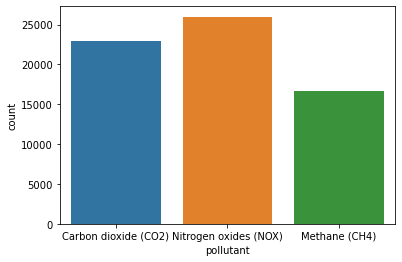

In [8]:
sns.countplot(data=raw_df, x=TARGET)
print(raw_df[TARGET].value_counts())

MONTH


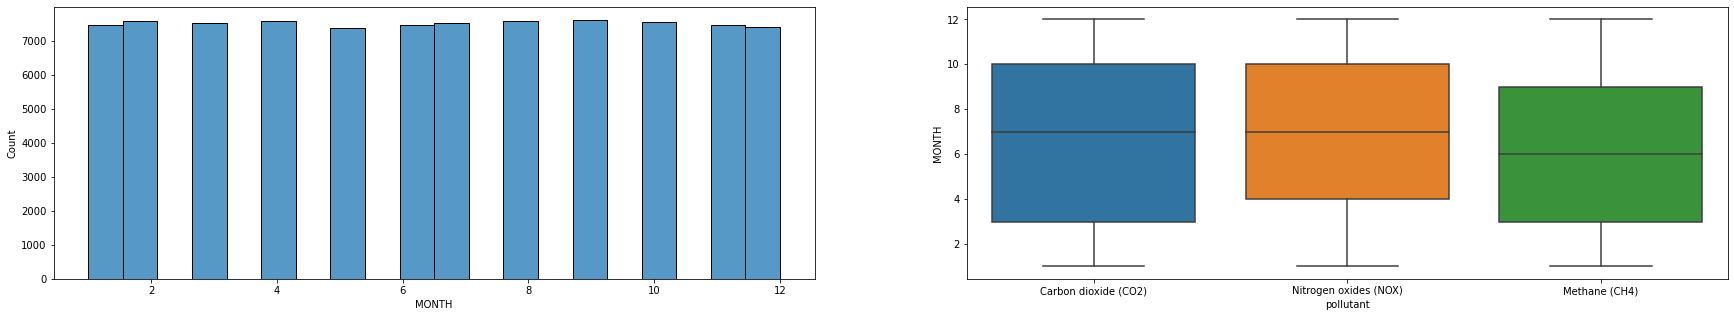

avg_temp


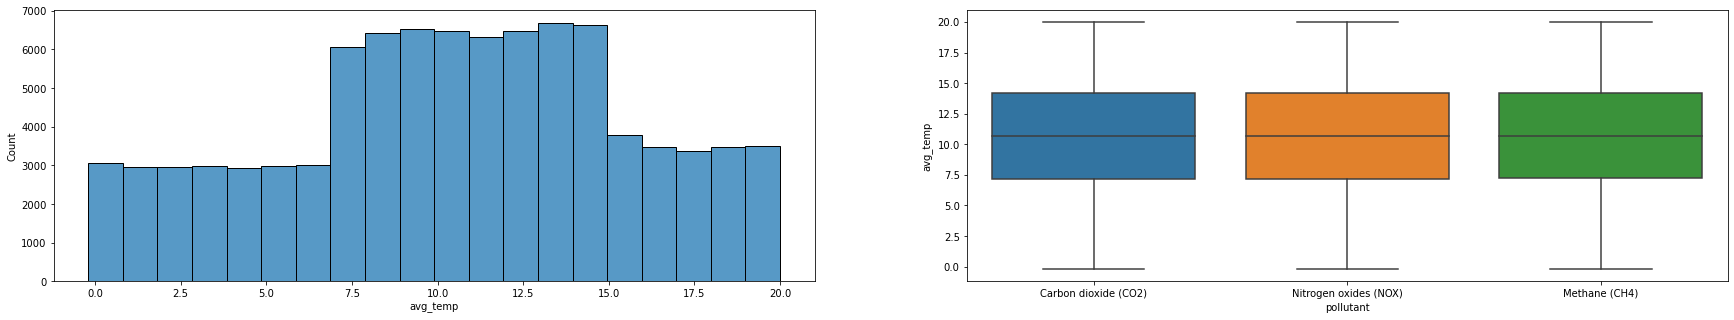

avg_wind_speed


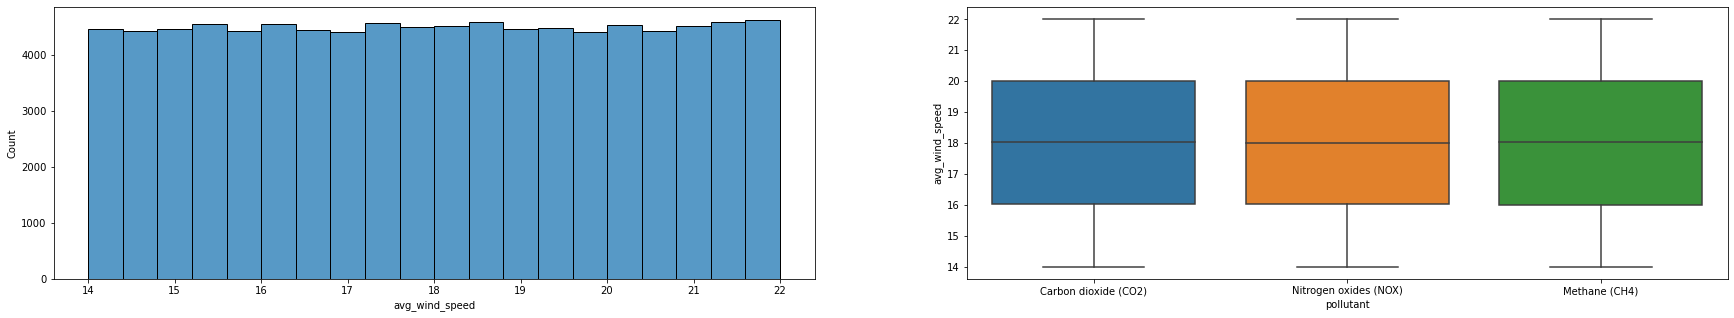

In [9]:
numeric_columns = ["MONTH", "avg_temp", "avg_wind_speed"]
for col in numeric_columns:
    print(col)
    f, (ax_hist, ax_box) = plt.subplots(1, 2, figsize=(30, 5))
    sns.histplot(data=raw_df, x=col, ax=ax_hist, bins=20)
    sns.boxplot(data=raw_df, x=TARGET, y=col)
    plt.show()

countryName


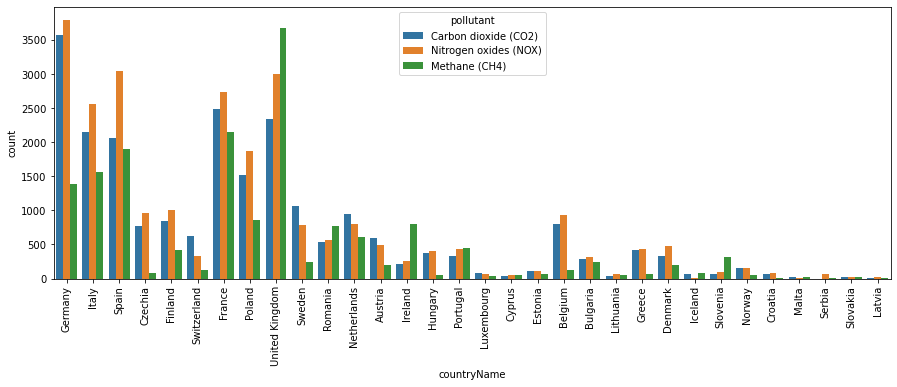

eprtrSectorName


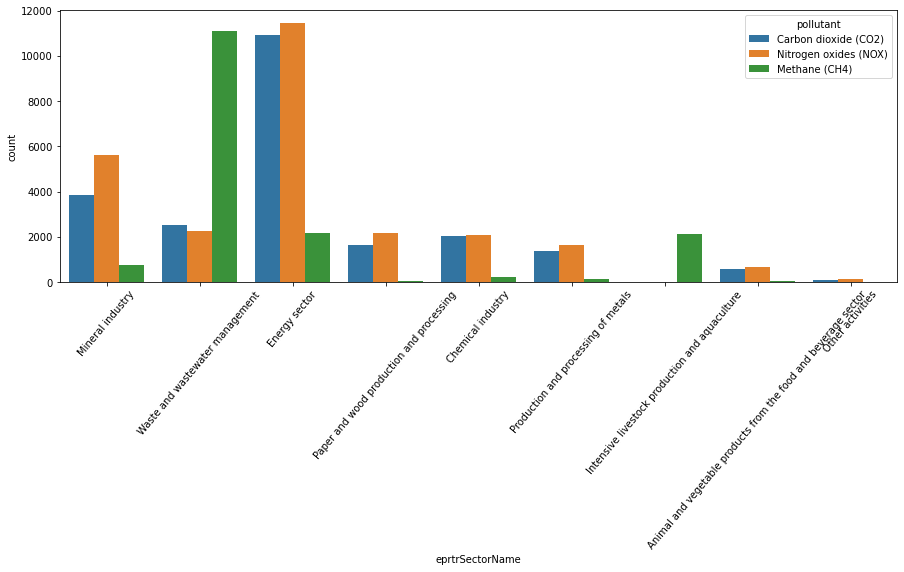

In [10]:
categorical_columns = ["countryName", "eprtrSectorName"]
for col in categorical_columns:
    print(col)
    plt.figure(figsize=(15, 5))
    if len(raw_df[col].unique()) > 13:
        plt.xticks(rotation=90)
    elif len(raw_df[col].unique()) > 8:
        plt.xticks(rotation=50)
    sns.countplot(data=raw_df, x=col, hue=TARGET)
    plt.show()

## Preprocessing

In [11]:
prep_df = raw_df.copy(deep=True)
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90108 entries, 0 to 90107
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   countryName                   90108 non-null  object 
 1   eprtrSectorName               90108 non-null  object 
 2   EPRTRAnnexIMainActivityLabel  90108 non-null  object 
 3   FacilityInspireID             90108 non-null  object 
 4   facilityName                  90108 non-null  object 
 5   City                          90108 non-null  object 
 6   targetRelease                 90108 non-null  object 
 7   pollutant                     65628 non-null  object 
 8   reportingYear                 90108 non-null  int8   
 9   MONTH                         90108 non-null  int8   
 10  DAY                           90108 non-null  int8   
 11  CONTINENT                     90108 non-null  object 
 12  max_wind_speed                90108 non-null  float64
 13  a

### Remove columns

In [12]:
to_remove = [
    "EPRTRSectorCode",
    "EPRTRAnnexIMainActivityCode",

    "targetRelease",
    "City",
    "CONTINENT",

    "REPORTER NAME"
]

prep_df = prep_df.drop(to_remove, axis=1)
print(f"prep_df after drop columns {prep_df.shape}")

prep_df after drop columns (90108, 18)


### Generate features

In [13]:
feature_generator = FeatureGenerator(prep_df)

In [14]:
to_encode = [
    "FacilityInspireID",
    "facilityName",
    "CITY ID",
]

prep_df = feature_generator.encode(to_encode)
print(f"prep_df after encode {prep_df.shape}")

prep_df after encode (90108, 21)


### One hot encoding

In [15]:
to_one_hot_encode = [
    "countryName",
    "eprtrSectorName",
    "EPRTRAnnexIMainActivityLabel"
]

prep_df = encode_dataframe(prep_df, to_one_hot_encode)

columns to encode: ['countryName', 'eprtrSectorName', 'EPRTRAnnexIMainActivityLabel']
dataframe before one-hot encoding: (90108, 21)
dataframe after one-hot encoding:  (90108, 130)


### pollutant to number

In [16]:
dict_target = {
    "Nitrogen oxides (NOX)": 0,
    "Carbon dioxide (CO2)": 1,
    "Methane (CH4)": 2,
}
prep_df[TARGET] = prep_df[TARGET].apply(lambda value: dict_target[value] if type(value) == str else value)

## Modelling

In [17]:
dev_df = prep_df[prep_df['test_index'].isnull()]
print('* dev_df shape:', dev_df.shape)

val_df = prep_df[prep_df['test_index'].notnull()]
print('* val_df shape:', val_df.shape)

* dev_df shape: (65628, 130)
* val_df shape: (24480, 130)


In [18]:
dev_df_X = dev_df.drop([TARGET, 'test_index'], axis=1)
dev_df_y = dev_df[[TARGET]]
val_df_x = val_df.drop(TARGET, axis=1)
X_train, X_test, y_train, y_test = train_test_split(dev_df_X, dev_df_y, test_size=0.2, random_state=42)

In [19]:
print(f"""
TRAIN:
    X_train.shape: {X_train.shape}
    y_train.shape: {y_train.shape}
TEST:
    X_test.shape: {X_test.shape}
    y_test.shape: {y_test.shape}
VAL:
    val_df_x.shape: {val_df_x.shape}
""")


TRAIN:
    X_train.shape: (52502, 128)
    y_train.shape: (52502, 1)
TEST:
    X_test.shape: (13126, 128)
    y_test.shape: (13126, 1)
VAL:
    val_df_x.shape: (24480, 129)



In [20]:
model: XGBClassifier = XGBClassifier(
    max_depth=3,
    min_child_weight=100,
    random_state=42,
    use_label_encoder=False,
    objective='multi:softprob',
    learning_rate=0.3,
    n_estimators=200,
)

eval_set = [(X_test, y_test.values.ravel())]
model.fit(
    X_train,
    y_train.values.ravel(),
    eval_metric="merror",
    eval_set=eval_set,
    verbose=True,
    early_stopping_rounds=10,
)

[0]	validation_0-merror:0.40964
[1]	validation_0-merror:0.40964
[2]	validation_0-merror:0.40964
[3]	validation_0-merror:0.40964
[4]	validation_0-merror:0.40172
[5]	validation_0-merror:0.40286
[6]	validation_0-merror:0.39540
[7]	validation_0-merror:0.39746
[8]	validation_0-merror:0.39723
[9]	validation_0-merror:0.39586
[10]	validation_0-merror:0.39647
[11]	validation_0-merror:0.38671
[12]	validation_0-merror:0.38580
[13]	validation_0-merror:0.38146
[14]	validation_0-merror:0.38077
[15]	validation_0-merror:0.37925
[16]	validation_0-merror:0.37689
[17]	validation_0-merror:0.37673
[18]	validation_0-merror:0.37612
[19]	validation_0-merror:0.37650
[20]	validation_0-merror:0.37650
[21]	validation_0-merror:0.37635
[22]	validation_0-merror:0.37452
[23]	validation_0-merror:0.37498
[24]	validation_0-merror:0.37551
[25]	validation_0-merror:0.37536
[26]	validation_0-merror:0.37506
[27]	validation_0-merror:0.37536
[28]	validation_0-merror:0.37498
[29]	validation_0-merror:0.37544
[30]	validation_0-me

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=3, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature Importance (Weight)'}, xlabel='F score', ylabel='Features'>

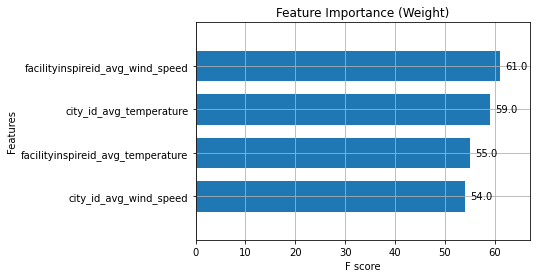

In [21]:
# "weight" is the number of times a feature appears in a tree
plot_importance(model, height=0.7, max_num_features=4, importance_type="weight",
                title="Feature Importance (Weight)")

In [22]:
y_pred = model.predict(X_test)
print('f1_score test', f1_score(y_test, y_pred, average='macro'))

y_pred_train = model.predict(X_train)
print('f1_score train', f1_score(y_train, y_pred_train, average='macro'))

f1_score test 0.6445555521267959
f1_score train 0.6432420871726774


## Best F1 score: 0.64

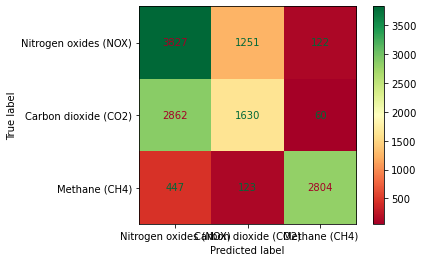

                       precision    recall  f1-score   support

Nitrogen oxides (NOX)       0.53      0.74      0.62     20782
 Carbon dioxide (CO2)       0.55      0.36      0.44     18412
        Methane (CH4)       0.94      0.82      0.87     13308

             accuracy                           0.63     52502
            macro avg       0.67      0.64      0.64     52502
         weighted avg       0.64      0.63      0.62     52502



In [23]:
plot_confusion_matrix(
    model,
    X_test,
    y_test,
    cmap="RdYlGn",
    display_labels=[
        "Nitrogen oxides (NOX)",
        "Carbon dioxide (CO2)",
        "Methane (CH4)"
    ]
)

plt.show()

print(classification_report(y_train, y_pred_train, target_names=[
    "Nitrogen oxides (NOX)",
    "Carbon dioxide (CO2)",
    "Methane (CH4)"
]))


## Test predictions

In [24]:
val_df_x.set_index('test_index', drop=True, inplace=True)
val_df_x.head()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,...,EPRTRAnnexIMainActivityLabel_Opencast mining and quarrying,"EPRTRAnnexIMainActivityLabel_Plants for the pre-treatment (operations such as washing, bleaching, mercerisation) or dyeing of fibres or textiles",EPRTRAnnexIMainActivityLabel_Slaughterhouses,EPRTRAnnexIMainActivityLabel_Thermal power stations and other combustion installations,EPRTRAnnexIMainActivityLabel_Treatment and processing intended for the production of food and beverage products from animal raw materials (other than milk),EPRTRAnnexIMainActivityLabel_Treatment and processing intended for the production of food and beverage products from vegetable raw materials,"EPRTRAnnexIMainActivityLabel_Treatment and processing intended for the production of food and beverage products. Note to reporters, use Level 3 activity e.g. 8(b)(i), in preference to 8(b). Level 2 activity class (i.e. 8(b)) only to be used where Level 3 is not available.",EPRTRAnnexIMainActivityLabel_Treatment and processing of milk,EPRTRAnnexIMainActivityLabel_Underground mining and related operations,EPRTRAnnexIMainActivityLabel_Urban waste-water treatment plants
test_index,,,,,,,,,,,,,,,,,,,,,
0.0,-31,8,16,14.080054,14.855940,18.474836,10.278561,11.381181,13.480752,1,...,0,0,0,0,0,0,0,0,1,0
1.0,-40,11,22,16.052425,17.623877,22.622900,6.625910,8.840137,13.422924,0,...,0,0,0,0,0,0,0,0,0,0
2.0,-34,9,19,13.647318,15.541979,17.818521,5.669436,8.403322,11.276388,2,...,0,0,0,1,0,0,0,0,0,0
3.0,-37,7,17,16.336762,17.458113,19.961777,6.160560,7.571596,9.443572,2,...,0,0,0,0,0,0,0,0,0,0
4.0,-38,6,23,21.516602,20.532473,21.617137,10.964012,11.548033,12.624114,2,...,0,0,0,1,0,0,0,0,0,0


In [25]:
y_pred_test = model.predict(val_df_x)

In [26]:
test_prediction_dict = {
    'test_index': val_df_x.reset_index()['test_index'].to_list(),
    TARGET: y_pred_test
}
predictions = pd.DataFrame(data=test_prediction_dict).astype({'test_index': 'int', TARGET: 'int8'})
predictions

,test_index,pollutant
0,0,2
1,1,2
2,2,1
3,3,2
4,4,0
...,...,...
24475,24475,1
24476,24476,0
24477,24477,2
24478,24478,1


In [27]:
predictions.to_csv("predictions.csv", index=False)
predictions.to_json("predictions.json")